<a href="https://colab.research.google.com/github/rana7210/AlphaFold_Experiment/blob/main/AlphaFold2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/sokrypton/ColabFold/main/.github/ColabFold_Marv_Logo_Small.png" height="200" align="right" style="height:240px">

##ColabFold v1.5.5: AlphaFold2 using MMseqs2

Easy to use protein structure and complex prediction using [AlphaFold2](https://www.nature.com/articles/s41586-021-03819-2) and [Alphafold2-multimer](https://www.biorxiv.org/content/10.1101/2021.10.04.463034v1). Sequence alignments/templates are generated through [MMseqs2](mmseqs.com) and [HHsearch](https://github.com/soedinglab/hh-suite). For more details, see <a href="#Instructions">bottom</a> of the notebook, checkout the [ColabFold GitHub](https://github.com/sokrypton/ColabFold) and [Nature Protocols](https://www.nature.com/articles/s41596-024-01060-5).

Old versions: [v1.4](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.4.0/AlphaFold2.ipynb), [v1.5.1](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.5.1/AlphaFold2.ipynb), [v1.5.2](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.5.2/AlphaFold2.ipynb), [v1.5.3-patch](https://colab.research.google.com/github/sokrypton/ColabFold/blob/56c72044c7d51a311ca99b953a71e552fdc042e1/AlphaFold2.ipynb)

[Mirdita M, Schütze K, Moriwaki Y, Heo L, Ovchinnikov S, Steinegger M. ColabFold: Making protein folding accessible to all.
*Nature Methods*, 2022](https://www.nature.com/articles/s41592-022-01488-1)

In [ ]:
#@title Input protein sequence(s), then hit `Runtime` -> `Run all`
from google.colab import files
import os
import re
import hashlib
import random

In [ ]:
from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

In [ ]:
# REPLACE the whole multi-line block with the colon-separated version (no headers)
query_sequence = (
  "query_sequence = "MNKITNKVKPPAQKAVGKSASKITVGSKAPYNLKWSKGAYFNAKIDGLGATSATRYGDNRTNYRFDVGQAVYAPGTLIYVFEIIDGWCRIYWNNHNEWIWHERLIVKEVF:MTVLAQTTLPANADNGAFAALAAEQFGNGWSVVGNFGEAQEQQQSRQVVTFVHGKFIQLVDGRAKTVAVGKELGAAEVIKS"
"
)


In [ ]:

#@markdown  - Use `:` to specify inter-protein chainbreaks for **modeling complexes** (supports homo- and hetro-oligomers). For example **PI...SK:PI...SK** for a homodimer
jobname = 'itCBD and CspA 3' #@param {type:"string"}
# number of models to use
num_relax = 0 #@param [0, 1, 5] {type:"raw"}
#@markdown - specify how many of the top ranked structures to relax using amber
template_mode = "none" #@param ["none", "pdb100","custom"]
#@markdown - `none` = no template information is used. `pdb100` = detect templates in pdb100 (see [notes](#pdb100)). `custom` - upload and search own templates (PDB or mmCIF format, see [notes](#custom_templates))

use_amber = num_relax > 0

# remove whitespaces
query_sequence = "".join(query_sequence.split())

basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
jobname = add_hash(basejobname, query_sequence)

# check if directory with jobname exists
def check(folder):
  if os.path.exists(folder):
    return False
  else:
    return True
if not check(jobname):
  n = 0
  while not check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"

# make directory to save results
os.makedirs(jobname, exist_ok=True)

# save queries
queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
  text_file.write(f"id,sequence\n{jobname},{query_sequence}")

if template_mode == "pdb100":
  use_templates = True
  custom_template_path = None
elif template_mode == "custom":
  custom_template_path = os.path.join(jobname,f"template")
  os.makedirs(custom_template_path, exist_ok=True)
  uploaded = files.upload()
  use_templates = True
  for fn in uploaded.keys():
    os.rename(fn,os.path.join(custom_template_path,fn))
else:
  custom_template_path = None
  use_templates = False

print("jobname",jobname)
print("sequence",query_sequence)
print("length",len(query_sequence.replace(":","")))

In [ ]:
#@title Install dependencies
%%time
import os
USE_AMBER = use_amber
USE_TEMPLATES = use_templates
PYTHON_VERSION = python_version

if not os.path.isfile("COLABFOLD_READY"):
  print("installing colabfold...")
  os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
  if os.environ.get('TPU_NAME', False) != False:
    os.system("pip uninstall -y jax jaxlib")
    os.system("pip install --no-warn-conflicts --upgrade dm-haiku==0.0.10 'jax[cuda12_pip]'==0.3.25 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
  # hack to fix TF crash
  os.system("rm -f /usr/local/lib/python3.*/dist-packages/tensorflow/core/kernels/libtfkernel_sobol_op.so")
  os.system("touch COLABFOLD_READY")

if USE_AMBER or USE_TEMPLATES:
  if not os.path.isfile("CONDA_READY"):
    print("installing conda...")
    os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Miniforge3-Linux-x86_64.sh")
    os.system("bash Miniforge3-Linux-x86_64.sh -bfp /usr/local")
    os.system("mamba config --set auto_update_conda false")
    os.system("touch CONDA_READY")

if USE_TEMPLATES and not os.path.isfile("HH_READY") and USE_AMBER and not os.path.isfile("AMBER_READY"):
  print("installing hhsuite and amber...")
  os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 openmm=8.2.0 python='{PYTHON_VERSION}' pdbfixer")
  os.system("touch HH_READY")
  os.system("touch AMBER_READY")
else:
  if USE_TEMPLATES and not os.path.isfile("HH_READY"):
    print("installing hhsuite...")
    os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python='{PYTHON_VERSION}'")
    os.system("touch HH_READY")
  if USE_AMBER and not os.path.isfile("AMBER_READY"):
    print("installing amber...")
    os.system(f"mamba install -y -c conda-forge openmm=8.2.0 python='{PYTHON_VERSION}' pdbfixer")
    os.system("touch AMBER_READY")

In [ ]:
#@markdown ### MSA options (custom MSA upload, single sequence, pairing mode)
msa_mode = "mmseqs2_uniref_env" #@param ["mmseqs2_uniref_env", "mmseqs2_uniref","single_sequence","custom"]
pair_mode = "unpaired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"}
#@markdown - "unpaired_paired" = pair sequences from same species + unpaired MSA, "unpaired" = seperate MSA for each chain, "paired" - only use paired sequences.

# decide which a3m to use
if "mmseqs2" in msa_mode:
  a3m_file = os.path.join(jobname,f"{jobname}.a3m")

elif msa_mode == "custom":
  a3m_file = os.path.join(jobname,f"{jobname}.custom.a3m")
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")

else:
  a3m_file = os.path.join(jobname,f"{jobname}.single_sequence.a3m")
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

In [ ]:
#@markdown ### Advanced settings
model_type = "auto" #@param ["auto", "alphafold2_ptm", "alphafold2_multimer_v1", "alphafold2_multimer_v2", "alphafold2_multimer_v3", "deepfold_v1", "alphafold2"]
#@markdown - if `auto` selected, will use `alphafold2_ptm` for monomer prediction and `alphafold2_multimer_v3` for complex prediction.
#@markdown Any of the mode_types can be used (regardless if input is monomer or complex).
num_recycles = "12" #@param ["auto", "0", "1", "3", "6", "12", "24", "48"]
#@markdown - if `auto` selected, will use `num_recycles=20` if `model_type=alphafold2_multimer_v3`, else `num_recycles=3` .
recycle_early_stop_tolerance = "auto" #@param ["auto", "0.0", "0.5", "1.0"]
#@markdown - if `auto` selected, will use `tol=0.5` if `model_type=alphafold2_multimer_v3` else `tol=0.0`.
relax_max_iterations = 200 #@param [0, 200, 2000] {type:"raw"}
#@markdown - max amber relax iterations, `0` = unlimited (AlphaFold2 default, can take very long)
pairing_strategy = "greedy" #@param ["greedy", "complete"] {type:"string"}
#@markdown - `greedy` = pair any taxonomically matching subsets, `complete` = all sequences have to match in one line.
calc_extra_ptm = True #@param {type:"boolean"}
#@markdown - return pairwise chain iptm/actifptm

#@markdown #### Sample settings
#@markdown -  enable dropouts and increase number of seeds to sample predictions from uncertainty of the model.
#@markdown -  decrease `max_msa` to increase uncertainity
max_msa = "auto" #@param ["auto", "512:1024", "256:512", "64:128", "32:64", "16:32"]
num_seeds = 8 #@param [1,2,4,8,16] {type:"raw"}
use_dropout = True #@param {type:"boolean"}

num_recycles = None if num_recycles == "auto" else int(num_recycles)
recycle_early_stop_tolerance = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
if max_msa == "auto": max_msa = None

#@markdown #### Save settings
save_all = False #@param {type:"boolean"}
save_recycles = False #@param {type:"boolean"}
save_to_google_drive = True #@param {type:"boolean"}
#@markdown -  if the save_to_google_drive option was selected, the result zip will be uploaded to your Google Drive
dpi = 300 #@param {type:"integer"}
#@markdown - set dpi for image resolution

if save_to_google_drive:
  from pydrive2.drive import GoogleDrive
  from pydrive2.auth import GoogleAuth
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  print("You are logged into Google Drive and are good to go!")

#@markdown Don't forget to hit `Runtime` -> `Run all` after updating the form.

2025-09-08 00:54:52,659 Running on GPU
2025-09-08 00:54:52,982 Found 5 citations for tools or databases
2025-09-08 00:54:52,983 Query 1/1: itCBDandCspA2_f1a6c (length 191)


PENDING:   0%|          | 0/300 [elapsed: 00:00 remaining: ?]

2025-09-08 00:54:53,670 Sleeping for 7s. Reason: PENDING


RUNNING:   2%|▏         | 7/300 [elapsed: 00:08 remaining: 05:50]

2025-09-08 00:55:01,362 Sleeping for 6s. Reason: RUNNING


RUNNING:   4%|▍         | 13/300 [elapsed: 00:15 remaining: 05:30]

2025-09-08 00:55:08,053 Sleeping for 6s. Reason: RUNNING


COMPLETE: 100%|██████████| 300/300 [elapsed: 00:22 remaining: 00:00]


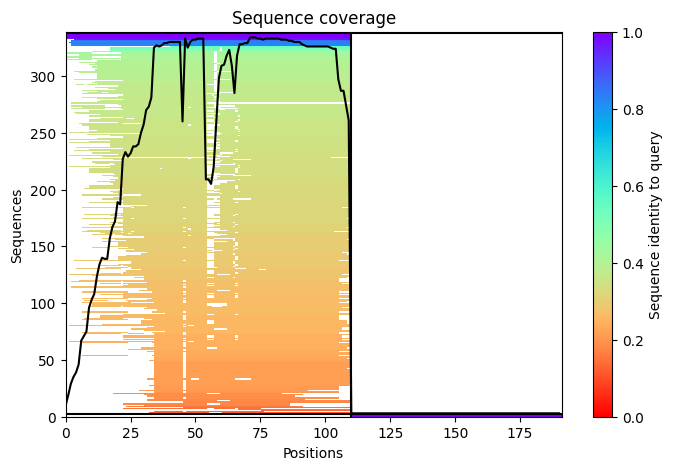

2025-09-08 00:55:16,743 Setting max_seq=339, max_extra_seq=1
2025-09-08 00:56:16,347 alphafold2_multimer_v3_model_1_seed_000 recycle=0 pLDDT=47.2 pTM=0.478 ipTM=0.12
2025-09-08 00:57:02,796 alphafold2_multimer_v3_model_1_seed_000 recycle=1 pLDDT=48.4 pTM=0.484 ipTM=0.123 tol=3.35
2025-09-08 00:57:11,130 alphafold2_multimer_v3_model_1_seed_000 recycle=2 pLDDT=50.1 pTM=0.486 ipTM=0.121 tol=3.27
2025-09-08 00:57:19,566 alphafold2_multimer_v3_model_1_seed_000 recycle=3 pLDDT=52 pTM=0.505 ipTM=0.137 tol=2.72
2025-09-08 00:57:28,085 alphafold2_multimer_v3_model_1_seed_000 recycle=4 pLDDT=52.8 pTM=0.516 ipTM=0.149 tol=0.906
2025-09-08 00:57:36,676 alphafold2_multimer_v3_model_1_seed_000 recycle=5 pLDDT=53.4 pTM=0.518 ipTM=0.151 tol=0.947
2025-09-08 00:57:45,397 alphafold2_multimer_v3_model_1_seed_000 recycle=6 pLDDT=53.8 pTM=0.522 ipTM=0.165 tol=1.15
2025-09-08 00:57:54,156 alphafold2_multimer_v3_model_1_seed_000 recycle=7 pLDDT=54 pTM=0.528 ipTM=0.18 tol=0.896
2025-09-08 00:58:02,921 alphafo

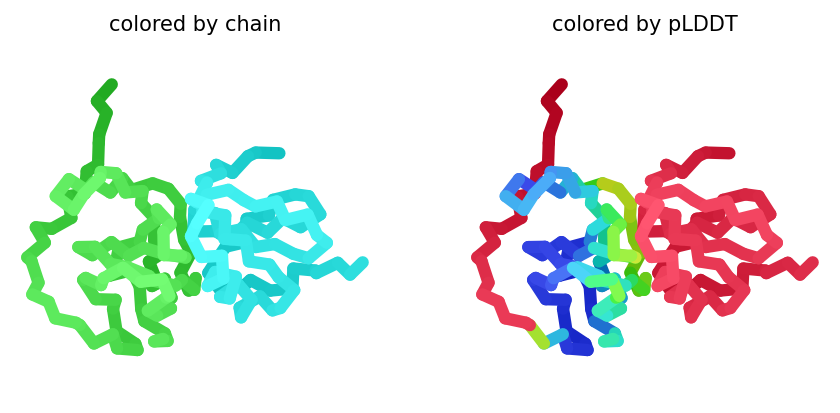

2025-09-08 00:58:49,347 alphafold2_multimer_v3_model_2_seed_000 recycle=0 pLDDT=49.2 pTM=0.488 ipTM=0.116
2025-09-08 00:58:57,977 alphafold2_multimer_v3_model_2_seed_000 recycle=1 pLDDT=52.1 pTM=0.512 ipTM=0.108 tol=2.24
2025-09-08 00:59:06,606 alphafold2_multimer_v3_model_2_seed_000 recycle=2 pLDDT=52.8 pTM=0.5 ipTM=0.104 tol=1.71
2025-09-08 00:59:15,299 alphafold2_multimer_v3_model_2_seed_000 recycle=3 pLDDT=51.6 pTM=0.487 ipTM=0.0986 tol=1.34
2025-09-08 00:59:23,985 alphafold2_multimer_v3_model_2_seed_000 recycle=4 pLDDT=52.1 pTM=0.496 ipTM=0.103 tol=0.922
2025-09-08 00:59:32,652 alphafold2_multimer_v3_model_2_seed_000 recycle=5 pLDDT=51.3 pTM=0.487 ipTM=0.0991 tol=1.33
2025-09-08 00:59:41,307 alphafold2_multimer_v3_model_2_seed_000 recycle=6 pLDDT=51.7 pTM=0.488 ipTM=0.106 tol=1.66
2025-09-08 00:59:49,933 alphafold2_multimer_v3_model_2_seed_000 recycle=7 pLDDT=51.5 pTM=0.493 ipTM=0.102 tol=1.23
2025-09-08 00:59:58,577 alphafold2_multimer_v3_model_2_seed_000 recycle=8 pLDDT=51.8 pTM

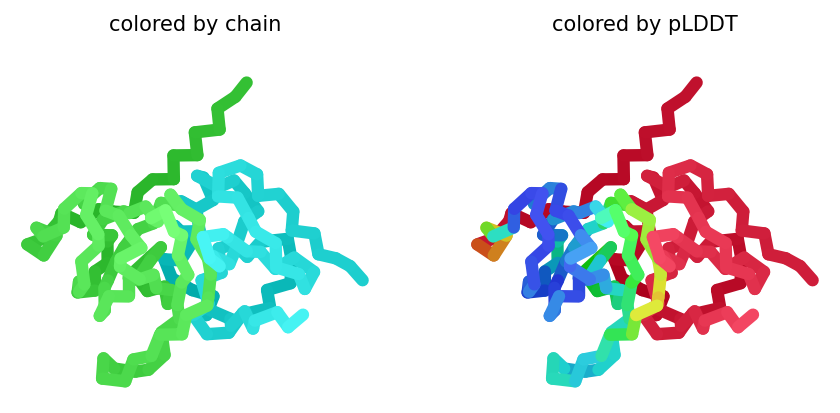

2025-09-08 01:00:41,840 alphafold2_multimer_v3_model_3_seed_000 recycle=0 pLDDT=53.8 pTM=0.516 ipTM=0.163
2025-09-08 01:00:50,471 alphafold2_multimer_v3_model_3_seed_000 recycle=1 pLDDT=52 pTM=0.501 ipTM=0.146 tol=5.93
2025-09-08 01:00:59,174 alphafold2_multimer_v3_model_3_seed_000 recycle=2 pLDDT=52.3 pTM=0.486 ipTM=0.116 tol=6.05
2025-09-08 01:01:07,834 alphafold2_multimer_v3_model_3_seed_000 recycle=3 pLDDT=52.5 pTM=0.489 ipTM=0.113 tol=6.43
2025-09-08 01:01:16,460 alphafold2_multimer_v3_model_3_seed_000 recycle=4 pLDDT=53.3 pTM=0.495 ipTM=0.11 tol=5.57
2025-09-08 01:01:25,091 alphafold2_multimer_v3_model_3_seed_000 recycle=5 pLDDT=53.5 pTM=0.501 ipTM=0.107 tol=1.86
2025-09-08 01:01:33,714 alphafold2_multimer_v3_model_3_seed_000 recycle=6 pLDDT=54.1 pTM=0.503 ipTM=0.118 tol=2.27
2025-09-08 01:01:42,334 alphafold2_multimer_v3_model_3_seed_000 recycle=7 pLDDT=56.9 pTM=0.504 ipTM=0.114 tol=4.58
2025-09-08 01:01:50,947 alphafold2_multimer_v3_model_3_seed_000 recycle=8 pLDDT=62.5 pTM=0.5

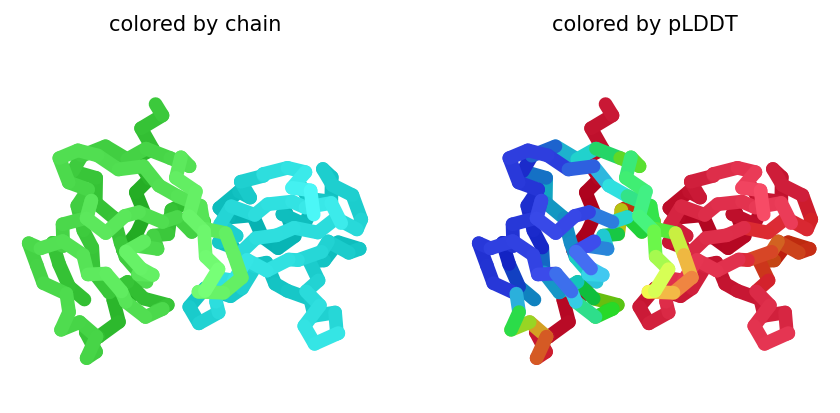

2025-09-08 01:02:34,361 alphafold2_multimer_v3_model_4_seed_000 recycle=0 pLDDT=50.1 pTM=0.492 ipTM=0.155
2025-09-08 01:02:43,009 alphafold2_multimer_v3_model_4_seed_000 recycle=1 pLDDT=51.4 pTM=0.504 ipTM=0.161 tol=4.04
2025-09-08 01:02:51,647 alphafold2_multimer_v3_model_4_seed_000 recycle=2 pLDDT=54.2 pTM=0.536 ipTM=0.154 tol=4.76
2025-09-08 01:03:00,343 alphafold2_multimer_v3_model_4_seed_000 recycle=3 pLDDT=57.8 pTM=0.563 ipTM=0.155 tol=1.9
2025-09-08 01:03:08,993 alphafold2_multimer_v3_model_4_seed_000 recycle=4 pLDDT=57 pTM=0.55 ipTM=0.161 tol=1.5
2025-09-08 01:03:17,627 alphafold2_multimer_v3_model_4_seed_000 recycle=5 pLDDT=57.2 pTM=0.539 ipTM=0.141 tol=1.03
2025-09-08 01:03:26,270 alphafold2_multimer_v3_model_4_seed_000 recycle=6 pLDDT=56.9 pTM=0.53 ipTM=0.149 tol=1.35
2025-09-08 01:03:34,897 alphafold2_multimer_v3_model_4_seed_000 recycle=7 pLDDT=56 pTM=0.521 ipTM=0.139 tol=1.62
2025-09-08 01:03:43,509 alphafold2_multimer_v3_model_4_seed_000 recycle=8 pLDDT=56.4 pTM=0.524 ip

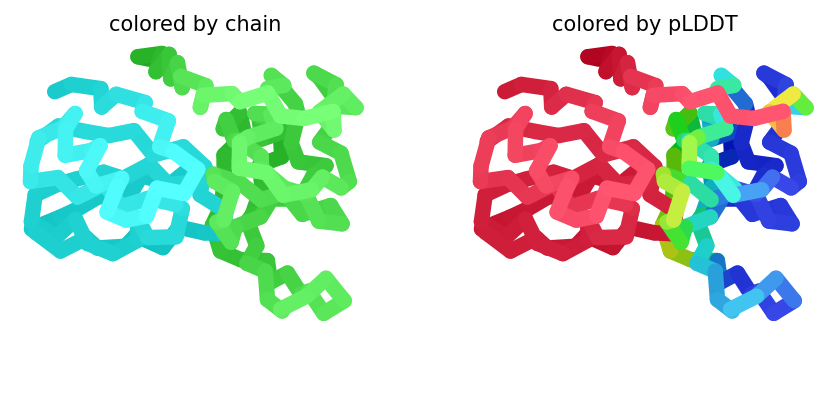

2025-09-08 01:04:26,917 alphafold2_multimer_v3_model_5_seed_000 recycle=0 pLDDT=50.5 pTM=0.521 ipTM=0.133
2025-09-08 01:04:35,602 alphafold2_multimer_v3_model_5_seed_000 recycle=1 pLDDT=52 pTM=0.521 ipTM=0.117 tol=4.6
2025-09-08 01:04:44,231 alphafold2_multimer_v3_model_5_seed_000 recycle=2 pLDDT=55.6 pTM=0.529 ipTM=0.135 tol=5.8
2025-09-08 01:04:52,854 alphafold2_multimer_v3_model_5_seed_000 recycle=3 pLDDT=55.6 pTM=0.533 ipTM=0.148 tol=1.98
2025-09-08 01:05:01,464 alphafold2_multimer_v3_model_5_seed_000 recycle=4 pLDDT=54.2 pTM=0.531 ipTM=0.146 tol=1.61
2025-09-08 01:05:10,091 alphafold2_multimer_v3_model_5_seed_000 recycle=5 pLDDT=54.3 pTM=0.53 ipTM=0.147 tol=1.2
2025-09-08 01:05:18,705 alphafold2_multimer_v3_model_5_seed_000 recycle=6 pLDDT=54 pTM=0.525 ipTM=0.144 tol=0.982
2025-09-08 01:05:27,306 alphafold2_multimer_v3_model_5_seed_000 recycle=7 pLDDT=54.5 pTM=0.535 ipTM=0.135 tol=1.17
2025-09-08 01:05:35,963 alphafold2_multimer_v3_model_5_seed_000 recycle=8 pLDDT=54.5 pTM=0.534 i

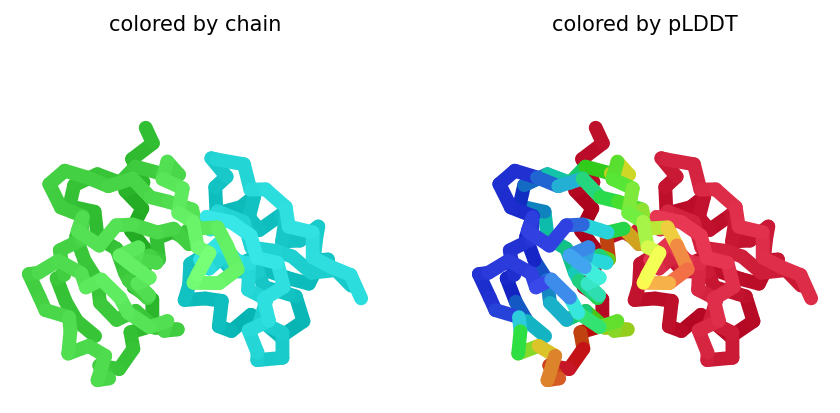

2025-09-08 01:06:19,374 alphafold2_multimer_v3_model_1_seed_001 recycle=0 pLDDT=50.2 pTM=0.5 ipTM=0.165
2025-09-08 01:06:27,997 alphafold2_multimer_v3_model_1_seed_001 recycle=1 pLDDT=50.3 pTM=0.501 ipTM=0.149 tol=2.49
2025-09-08 01:06:36,674 alphafold2_multimer_v3_model_1_seed_001 recycle=2 pLDDT=52 pTM=0.51 ipTM=0.153 tol=2.42
2025-09-08 01:06:45,316 alphafold2_multimer_v3_model_1_seed_001 recycle=3 pLDDT=52.5 pTM=0.51 ipTM=0.141 tol=2.35
2025-09-08 01:06:53,937 alphafold2_multimer_v3_model_1_seed_001 recycle=4 pLDDT=53.3 pTM=0.518 ipTM=0.156 tol=1.24
2025-09-08 01:07:02,546 alphafold2_multimer_v3_model_1_seed_001 recycle=5 pLDDT=52.8 pTM=0.518 ipTM=0.157 tol=0.732
2025-09-08 01:07:11,154 alphafold2_multimer_v3_model_1_seed_001 recycle=6 pLDDT=53.3 pTM=0.509 ipTM=0.137 tol=1.59
2025-09-08 01:07:19,755 alphafold2_multimer_v3_model_1_seed_001 recycle=7 pLDDT=53.2 pTM=0.512 ipTM=0.145 tol=1.09
2025-09-08 01:07:28,352 alphafold2_multimer_v3_model_1_seed_001 recycle=8 pLDDT=52.5 pTM=0.511

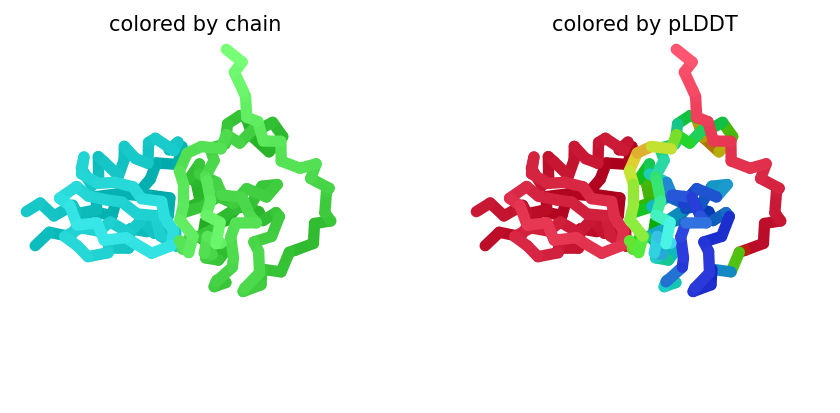

2025-09-08 01:08:11,779 alphafold2_multimer_v3_model_2_seed_001 recycle=0 pLDDT=47.6 pTM=0.463 ipTM=0.114
2025-09-08 01:08:20,405 alphafold2_multimer_v3_model_2_seed_001 recycle=1 pLDDT=53.3 pTM=0.507 ipTM=0.131 tol=5.2
2025-09-08 01:08:29,037 alphafold2_multimer_v3_model_2_seed_001 recycle=2 pLDDT=53.4 pTM=0.508 ipTM=0.128 tol=2.18
2025-09-08 01:08:37,725 alphafold2_multimer_v3_model_2_seed_001 recycle=3 pLDDT=54.3 pTM=0.505 ipTM=0.123 tol=1.83
2025-09-08 01:08:46,359 alphafold2_multimer_v3_model_2_seed_001 recycle=4 pLDDT=55 pTM=0.512 ipTM=0.128 tol=1.41
2025-09-08 01:08:54,979 alphafold2_multimer_v3_model_2_seed_001 recycle=5 pLDDT=55.1 pTM=0.519 ipTM=0.147 tol=1.15
2025-09-08 01:09:03,590 alphafold2_multimer_v3_model_2_seed_001 recycle=6 pLDDT=56 pTM=0.52 ipTM=0.142 tol=1.2
2025-09-08 01:09:12,212 alphafold2_multimer_v3_model_2_seed_001 recycle=7 pLDDT=56.5 pTM=0.518 ipTM=0.137 tol=0.604
2025-09-08 01:09:20,830 alphafold2_multimer_v3_model_2_seed_001 recycle=8 pLDDT=55.9 pTM=0.52 i

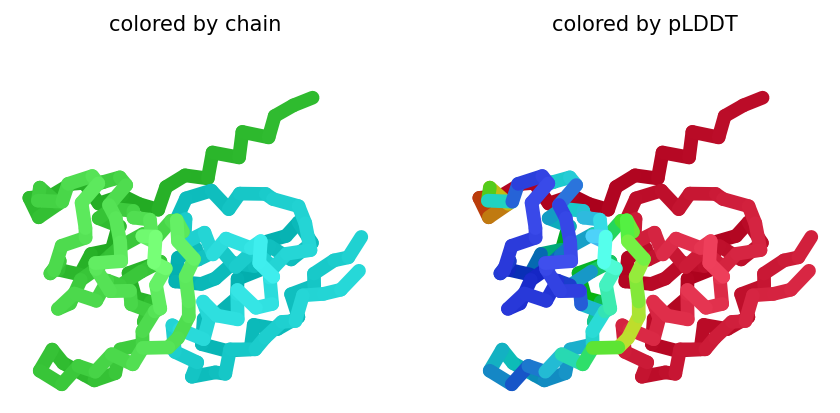

2025-09-08 01:10:04,285 alphafold2_multimer_v3_model_3_seed_001 recycle=0 pLDDT=50 pTM=0.478 ipTM=0.127
2025-09-08 01:10:12,931 alphafold2_multimer_v3_model_3_seed_001 recycle=1 pLDDT=52.3 pTM=0.501 ipTM=0.156 tol=3.58
2025-09-08 01:10:21,571 alphafold2_multimer_v3_model_3_seed_001 recycle=2 pLDDT=53.2 pTM=0.5 ipTM=0.139 tol=1.63
2025-09-08 01:10:30,192 alphafold2_multimer_v3_model_3_seed_001 recycle=3 pLDDT=54.3 pTM=0.505 ipTM=0.139 tol=0.934
2025-09-08 01:10:38,865 alphafold2_multimer_v3_model_3_seed_001 recycle=4 pLDDT=55.2 pTM=0.517 ipTM=0.164 tol=1.07
2025-09-08 01:10:47,485 alphafold2_multimer_v3_model_3_seed_001 recycle=5 pLDDT=55.2 pTM=0.517 ipTM=0.165 tol=1.13
2025-09-08 01:10:56,116 alphafold2_multimer_v3_model_3_seed_001 recycle=6 pLDDT=55.4 pTM=0.519 ipTM=0.16 tol=0.991
2025-09-08 01:11:04,727 alphafold2_multimer_v3_model_3_seed_001 recycle=7 pLDDT=55.5 pTM=0.517 ipTM=0.169 tol=1.25
2025-09-08 01:11:13,369 alphafold2_multimer_v3_model_3_seed_001 recycle=8 pLDDT=56.7 pTM=0.5

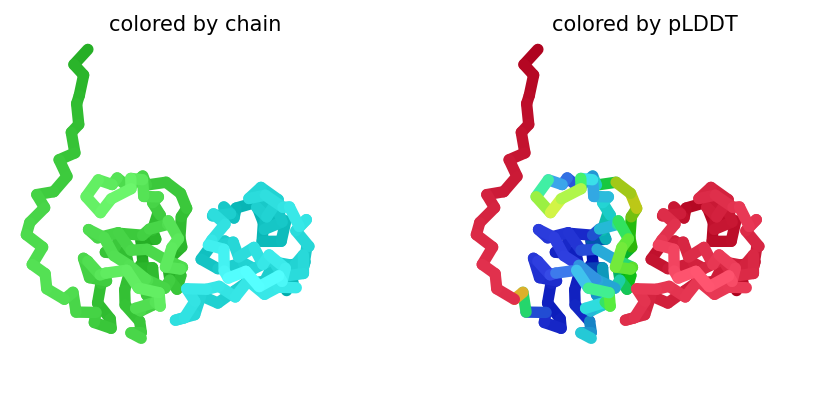

2025-09-08 01:11:56,729 alphafold2_multimer_v3_model_4_seed_001 recycle=0 pLDDT=48.8 pTM=0.5 ipTM=0.154
2025-09-08 01:12:05,359 alphafold2_multimer_v3_model_4_seed_001 recycle=1 pLDDT=53.3 pTM=0.52 ipTM=0.161 tol=3.99
2025-09-08 01:12:14,044 alphafold2_multimer_v3_model_4_seed_001 recycle=2 pLDDT=54.8 pTM=0.52 ipTM=0.151 tol=4.88
2025-09-08 01:12:22,673 alphafold2_multimer_v3_model_4_seed_001 recycle=3 pLDDT=55.2 pTM=0.523 ipTM=0.177 tol=4.11
2025-09-08 01:12:31,324 alphafold2_multimer_v3_model_4_seed_001 recycle=4 pLDDT=55.9 pTM=0.538 ipTM=0.195 tol=1.29
2025-09-08 01:12:39,957 alphafold2_multimer_v3_model_4_seed_001 recycle=5 pLDDT=56.3 pTM=0.539 ipTM=0.193 tol=1.26
2025-09-08 01:12:48,582 alphafold2_multimer_v3_model_4_seed_001 recycle=6 pLDDT=56.1 pTM=0.54 ipTM=0.195 tol=1
2025-09-08 01:12:57,226 alphafold2_multimer_v3_model_4_seed_001 recycle=7 pLDDT=56.6 pTM=0.54 ipTM=0.196 tol=0.958
2025-09-08 01:13:05,847 alphafold2_multimer_v3_model_4_seed_001 recycle=8 pLDDT=56.7 pTM=0.538 ip

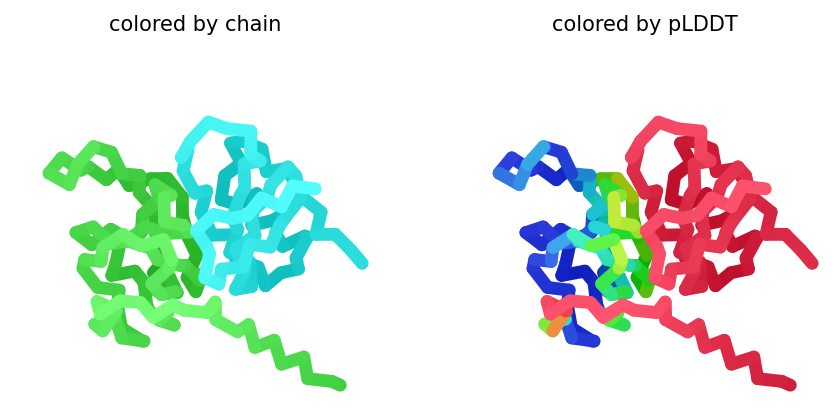

2025-09-08 01:13:49,290 alphafold2_multimer_v3_model_5_seed_001 recycle=0 pLDDT=51 pTM=0.52 ipTM=0.195
2025-09-08 01:13:57,920 alphafold2_multimer_v3_model_5_seed_001 recycle=1 pLDDT=53.9 pTM=0.544 ipTM=0.207 tol=4.8
2025-09-08 01:14:06,537 alphafold2_multimer_v3_model_5_seed_001 recycle=2 pLDDT=54.9 pTM=0.55 ipTM=0.222 tol=1.36
2025-09-08 01:14:15,222 alphafold2_multimer_v3_model_5_seed_001 recycle=3 pLDDT=54.7 pTM=0.535 ipTM=0.193 tol=1.63
2025-09-08 01:14:23,852 alphafold2_multimer_v3_model_5_seed_001 recycle=4 pLDDT=55.1 pTM=0.541 ipTM=0.21 tol=1.04
2025-09-08 01:14:32,497 alphafold2_multimer_v3_model_5_seed_001 recycle=5 pLDDT=56.3 pTM=0.548 ipTM=0.23 tol=1.29
2025-09-08 01:14:41,141 alphafold2_multimer_v3_model_5_seed_001 recycle=6 pLDDT=55.2 pTM=0.545 ipTM=0.208 tol=0.899
2025-09-08 01:14:49,783 alphafold2_multimer_v3_model_5_seed_001 recycle=7 pLDDT=55.6 pTM=0.542 ipTM=0.214 tol=1.02
2025-09-08 01:14:58,434 alphafold2_multimer_v3_model_5_seed_001 recycle=8 pLDDT=56 pTM=0.545 ip

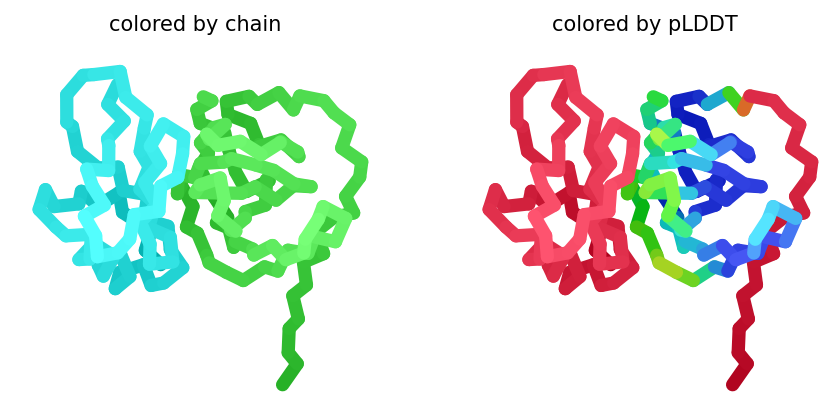

2025-09-08 01:15:41,810 alphafold2_multimer_v3_model_1_seed_002 recycle=0 pLDDT=48.6 pTM=0.493 ipTM=0.158
2025-09-08 01:15:50,419 alphafold2_multimer_v3_model_1_seed_002 recycle=1 pLDDT=49.7 pTM=0.498 ipTM=0.136 tol=3.97
2025-09-08 01:15:59,040 alphafold2_multimer_v3_model_1_seed_002 recycle=2 pLDDT=51.5 pTM=0.503 ipTM=0.139 tol=2.95
2025-09-08 01:16:07,679 alphafold2_multimer_v3_model_1_seed_002 recycle=3 pLDDT=53.2 pTM=0.518 ipTM=0.161 tol=1.78
2025-09-08 01:16:16,379 alphafold2_multimer_v3_model_1_seed_002 recycle=4 pLDDT=53.8 pTM=0.52 ipTM=0.161 tol=0.793
2025-09-08 01:16:25,021 alphafold2_multimer_v3_model_1_seed_002 recycle=5 pLDDT=53.3 pTM=0.521 ipTM=0.151 tol=1.2
2025-09-08 01:16:33,651 alphafold2_multimer_v3_model_1_seed_002 recycle=6 pLDDT=53.7 pTM=0.527 ipTM=0.168 tol=0.606
2025-09-08 01:16:42,271 alphafold2_multimer_v3_model_1_seed_002 recycle=7 pLDDT=54.1 pTM=0.52 ipTM=0.155 tol=0.938
2025-09-08 01:16:50,888 alphafold2_multimer_v3_model_1_seed_002 recycle=8 pLDDT=54 pTM=0.

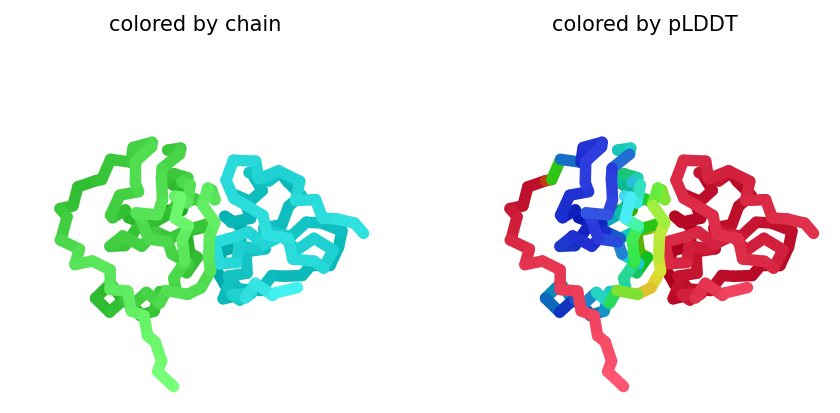

2025-09-08 01:17:34,233 alphafold2_multimer_v3_model_2_seed_002 recycle=0 pLDDT=50.7 pTM=0.491 ipTM=0.159
2025-09-08 01:17:42,849 alphafold2_multimer_v3_model_2_seed_002 recycle=1 pLDDT=51.7 pTM=0.504 ipTM=0.152 tol=6.66
2025-09-08 01:17:51,507 alphafold2_multimer_v3_model_2_seed_002 recycle=2 pLDDT=53 pTM=0.5 ipTM=0.141 tol=1.58
2025-09-08 01:18:00,119 alphafold2_multimer_v3_model_2_seed_002 recycle=3 pLDDT=53.8 pTM=0.503 ipTM=0.145 tol=1.56
2025-09-08 01:18:08,731 alphafold2_multimer_v3_model_2_seed_002 recycle=4 pLDDT=54.2 pTM=0.509 ipTM=0.147 tol=1.33
2025-09-08 01:18:17,362 alphafold2_multimer_v3_model_2_seed_002 recycle=5 pLDDT=54.6 pTM=0.512 ipTM=0.152 tol=1.22
2025-09-08 01:18:25,996 alphafold2_multimer_v3_model_2_seed_002 recycle=6 pLDDT=54.5 pTM=0.514 ipTM=0.148 tol=1.67
2025-09-08 01:18:34,631 alphafold2_multimer_v3_model_2_seed_002 recycle=7 pLDDT=54.9 pTM=0.511 ipTM=0.144 tol=1.87
2025-09-08 01:18:43,278 alphafold2_multimer_v3_model_2_seed_002 recycle=8 pLDDT=54.5 pTM=0.50

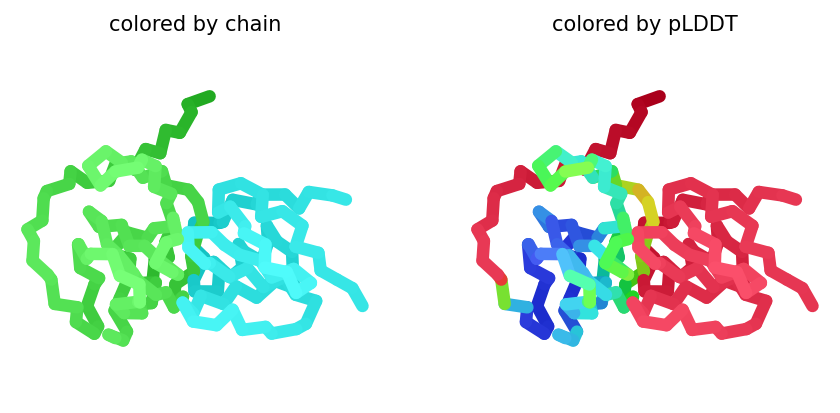

2025-09-08 01:19:26,678 alphafold2_multimer_v3_model_3_seed_002 recycle=0 pLDDT=51.8 pTM=0.49 ipTM=0.155
2025-09-08 01:19:35,308 alphafold2_multimer_v3_model_3_seed_002 recycle=1 pLDDT=52.2 pTM=0.495 ipTM=0.121 tol=7.94
2025-09-08 01:19:43,912 alphafold2_multimer_v3_model_3_seed_002 recycle=2 pLDDT=53.4 pTM=0.496 ipTM=0.121 tol=3.22
2025-09-08 01:19:52,579 alphafold2_multimer_v3_model_3_seed_002 recycle=3 pLDDT=61.5 pTM=0.545 ipTM=0.151 tol=4.85
2025-09-08 01:20:01,198 alphafold2_multimer_v3_model_3_seed_002 recycle=4 pLDDT=62.7 pTM=0.552 ipTM=0.179 tol=0.927
2025-09-08 01:20:09,806 alphafold2_multimer_v3_model_3_seed_002 recycle=5 pLDDT=59.2 pTM=0.523 ipTM=0.124 tol=2.62
2025-09-08 01:20:18,419 alphafold2_multimer_v3_model_3_seed_002 recycle=6 pLDDT=59.7 pTM=0.519 ipTM=0.126 tol=1.37
2025-09-08 01:20:27,063 alphafold2_multimer_v3_model_3_seed_002 recycle=7 pLDDT=59.8 pTM=0.532 ipTM=0.15 tol=1.98
2025-09-08 01:20:35,701 alphafold2_multimer_v3_model_3_seed_002 recycle=8 pLDDT=60.3 pTM=0

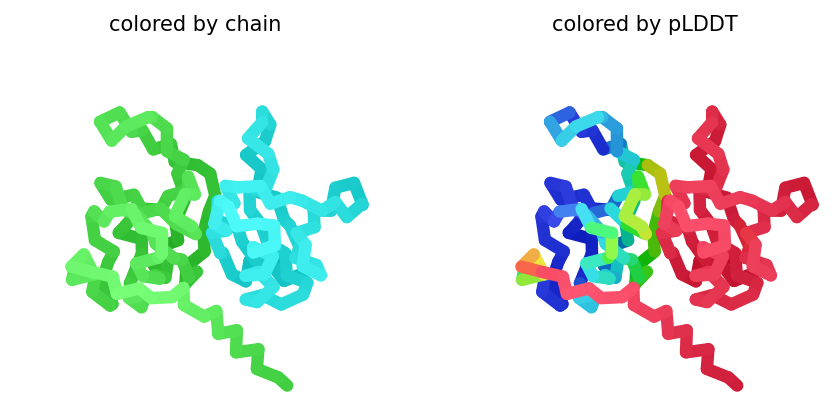

2025-09-08 01:21:19,074 alphafold2_multimer_v3_model_4_seed_002 recycle=0 pLDDT=48.9 pTM=0.481 ipTM=0.132
2025-09-08 01:21:27,694 alphafold2_multimer_v3_model_4_seed_002 recycle=1 pLDDT=50.6 pTM=0.504 ipTM=0.138 tol=4.08
2025-09-08 01:21:36,295 alphafold2_multimer_v3_model_4_seed_002 recycle=2 pLDDT=50.6 pTM=0.502 ipTM=0.141 tol=5.34
2025-09-08 01:21:44,912 alphafold2_multimer_v3_model_4_seed_002 recycle=3 pLDDT=55.1 pTM=0.525 ipTM=0.179 tol=2.67
2025-09-08 01:21:53,574 alphafold2_multimer_v3_model_4_seed_002 recycle=4 pLDDT=55.7 pTM=0.531 ipTM=0.184 tol=5.61
2025-09-08 01:22:02,196 alphafold2_multimer_v3_model_4_seed_002 recycle=5 pLDDT=55.3 pTM=0.534 ipTM=0.189 tol=1.34
2025-09-08 01:22:10,809 alphafold2_multimer_v3_model_4_seed_002 recycle=6 pLDDT=55.4 pTM=0.534 ipTM=0.192 tol=0.81
2025-09-08 01:22:19,425 alphafold2_multimer_v3_model_4_seed_002 recycle=7 pLDDT=55.9 pTM=0.538 ipTM=0.197 tol=0.727
2025-09-08 01:22:28,050 alphafold2_multimer_v3_model_4_seed_002 recycle=8 pLDDT=55.9 pTM

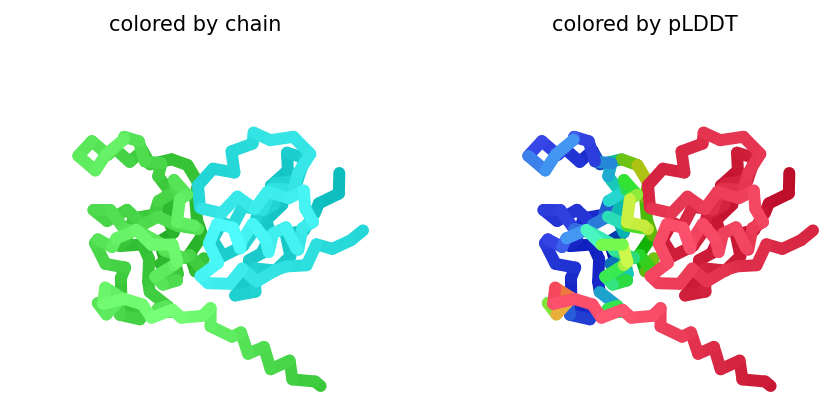

2025-09-08 01:23:11,486 alphafold2_multimer_v3_model_5_seed_002 recycle=0 pLDDT=48.9 pTM=0.481 ipTM=0.144
2025-09-08 01:23:20,095 alphafold2_multimer_v3_model_5_seed_002 recycle=1 pLDDT=49.8 pTM=0.492 ipTM=0.105 tol=5.17
2025-09-08 01:23:28,739 alphafold2_multimer_v3_model_5_seed_002 recycle=2 pLDDT=50 pTM=0.493 ipTM=0.124 tol=3.4
2025-09-08 01:23:37,348 alphafold2_multimer_v3_model_5_seed_002 recycle=3 pLDDT=52 pTM=0.508 ipTM=0.129 tol=3.71
2025-09-08 01:23:45,975 alphafold2_multimer_v3_model_5_seed_002 recycle=4 pLDDT=52.5 pTM=0.517 ipTM=0.124 tol=2.79
2025-09-08 01:23:54,606 alphafold2_multimer_v3_model_5_seed_002 recycle=5 pLDDT=52.7 pTM=0.519 ipTM=0.121 tol=2.24
2025-09-08 01:24:03,253 alphafold2_multimer_v3_model_5_seed_002 recycle=6 pLDDT=54.3 pTM=0.524 ipTM=0.126 tol=2.23
2025-09-08 01:24:11,922 alphafold2_multimer_v3_model_5_seed_002 recycle=7 pLDDT=54.6 pTM=0.534 ipTM=0.156 tol=2.37
2025-09-08 01:24:20,554 alphafold2_multimer_v3_model_5_seed_002 recycle=8 pLDDT=54.5 pTM=0.533

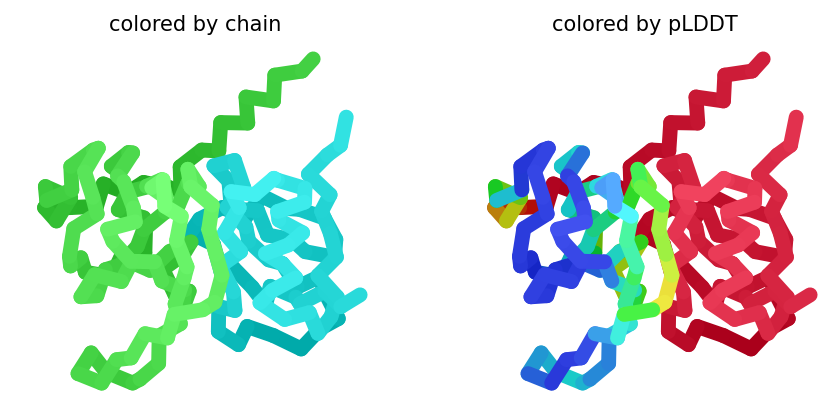

2025-09-08 01:25:03,989 alphafold2_multimer_v3_model_1_seed_003 recycle=0 pLDDT=49.9 pTM=0.499 ipTM=0.136
2025-09-08 01:25:12,606 alphafold2_multimer_v3_model_1_seed_003 recycle=1 pLDDT=50.4 pTM=0.513 ipTM=0.146 tol=3.18
2025-09-08 01:25:21,203 alphafold2_multimer_v3_model_1_seed_003 recycle=2 pLDDT=51.7 pTM=0.513 ipTM=0.123 tol=1.81
2025-09-08 01:25:29,860 alphafold2_multimer_v3_model_1_seed_003 recycle=3 pLDDT=52.8 pTM=0.524 ipTM=0.146 tol=6.62
2025-09-08 01:25:38,484 alphafold2_multimer_v3_model_1_seed_003 recycle=4 pLDDT=54 pTM=0.528 ipTM=0.155 tol=3
2025-09-08 01:25:47,113 alphafold2_multimer_v3_model_1_seed_003 recycle=5 pLDDT=53.8 pTM=0.523 ipTM=0.152 tol=1.66
2025-09-08 01:25:55,750 alphafold2_multimer_v3_model_1_seed_003 recycle=6 pLDDT=54.6 pTM=0.534 ipTM=0.174 tol=1
2025-09-08 01:26:04,392 alphafold2_multimer_v3_model_1_seed_003 recycle=7 pLDDT=54.4 pTM=0.534 ipTM=0.173 tol=1.19
2025-09-08 01:26:13,033 alphafold2_multimer_v3_model_1_seed_003 recycle=8 pLDDT=54 pTM=0.527 ipTM

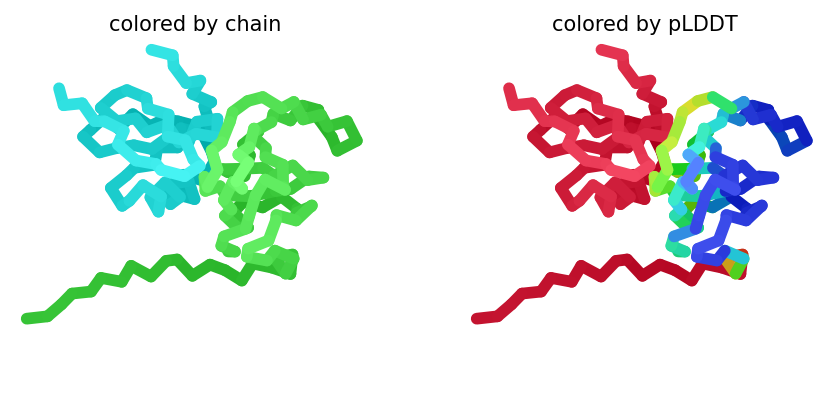

2025-09-08 01:26:56,405 alphafold2_multimer_v3_model_2_seed_003 recycle=0 pLDDT=50.8 pTM=0.483 ipTM=0.108
2025-09-08 01:27:05,085 alphafold2_multimer_v3_model_2_seed_003 recycle=1 pLDDT=51.8 pTM=0.491 ipTM=0.108 tol=3.13
2025-09-08 01:27:13,723 alphafold2_multimer_v3_model_2_seed_003 recycle=2 pLDDT=50.4 pTM=0.487 ipTM=0.102 tol=3.09
2025-09-08 01:27:22,361 alphafold2_multimer_v3_model_2_seed_003 recycle=3 pLDDT=52.7 pTM=0.507 ipTM=0.112 tol=2.79
2025-09-08 01:27:30,985 alphafold2_multimer_v3_model_2_seed_003 recycle=4 pLDDT=54.1 pTM=0.507 ipTM=0.116 tol=1.55
2025-09-08 01:27:39,611 alphafold2_multimer_v3_model_2_seed_003 recycle=5 pLDDT=55 pTM=0.512 ipTM=0.125 tol=1.5
2025-09-08 01:27:48,228 alphafold2_multimer_v3_model_2_seed_003 recycle=6 pLDDT=55.2 pTM=0.518 ipTM=0.136 tol=1.42
2025-09-08 01:27:56,859 alphafold2_multimer_v3_model_2_seed_003 recycle=7 pLDDT=55 pTM=0.518 ipTM=0.132 tol=1.25
2025-09-08 01:28:05,541 alphafold2_multimer_v3_model_2_seed_003 recycle=8 pLDDT=54.6 pTM=0.513

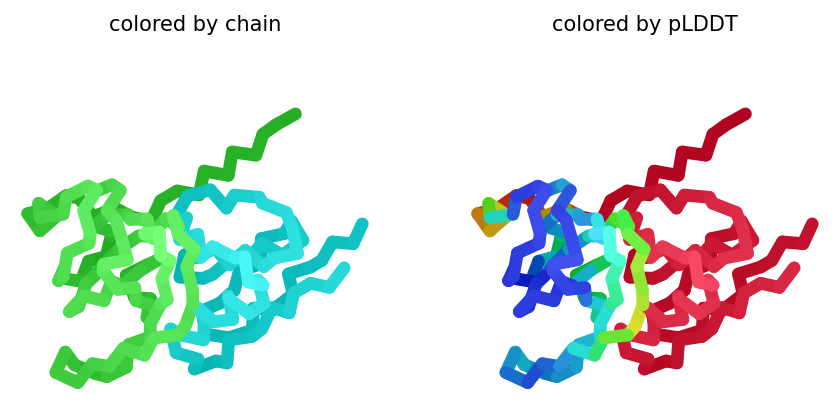

2025-09-08 01:28:48,902 alphafold2_multimer_v3_model_3_seed_003 recycle=0 pLDDT=52.2 pTM=0.48 ipTM=0.137
2025-09-08 01:28:57,504 alphafold2_multimer_v3_model_3_seed_003 recycle=1 pLDDT=53.8 pTM=0.494 ipTM=0.133 tol=4.25
2025-09-08 01:29:06,176 alphafold2_multimer_v3_model_3_seed_003 recycle=2 pLDDT=57.4 pTM=0.538 ipTM=0.204 tol=5.04
2025-09-08 01:29:14,805 alphafold2_multimer_v3_model_3_seed_003 recycle=3 pLDDT=58.5 pTM=0.525 ipTM=0.182 tol=1.95
2025-09-08 01:29:23,459 alphafold2_multimer_v3_model_3_seed_003 recycle=4 pLDDT=60.5 pTM=0.533 ipTM=0.187 tol=1.44
2025-09-08 01:29:32,107 alphafold2_multimer_v3_model_3_seed_003 recycle=5 pLDDT=60.8 pTM=0.556 ipTM=0.24 tol=0.851
2025-09-08 01:29:40,747 alphafold2_multimer_v3_model_3_seed_003 recycle=6 pLDDT=61.7 pTM=0.57 ipTM=0.272 tol=4.22
2025-09-08 01:29:49,383 alphafold2_multimer_v3_model_3_seed_003 recycle=7 pLDDT=61.7 pTM=0.565 ipTM=0.256 tol=1.98
2025-09-08 01:29:58,001 alphafold2_multimer_v3_model_3_seed_003 recycle=8 pLDDT=60.3 pTM=0.

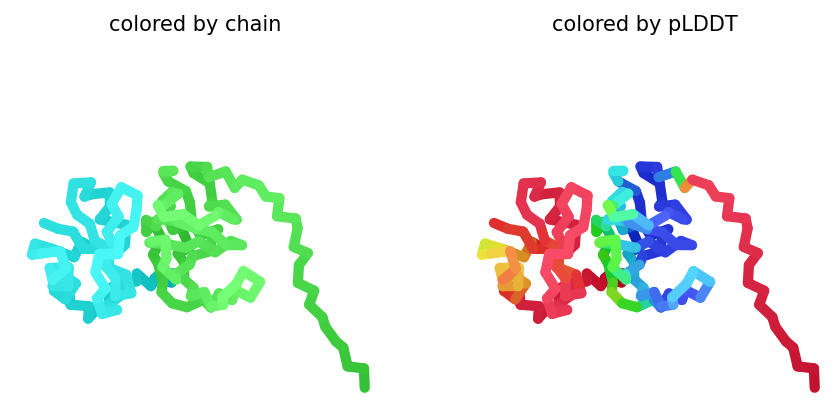

2025-09-08 01:30:41,384 alphafold2_multimer_v3_model_4_seed_003 recycle=0 pLDDT=51.9 pTM=0.517 ipTM=0.145
2025-09-08 01:30:50,038 alphafold2_multimer_v3_model_4_seed_003 recycle=1 pLDDT=55.1 pTM=0.539 ipTM=0.161 tol=3.46
2025-09-08 01:30:58,678 alphafold2_multimer_v3_model_4_seed_003 recycle=2 pLDDT=56.7 pTM=0.547 ipTM=0.178 tol=1.36
2025-09-08 01:31:07,375 alphafold2_multimer_v3_model_4_seed_003 recycle=3 pLDDT=58 pTM=0.562 ipTM=0.169 tol=0.911
2025-09-08 01:31:15,993 alphafold2_multimer_v3_model_4_seed_003 recycle=4 pLDDT=57.5 pTM=0.557 ipTM=0.185 tol=1.03
2025-09-08 01:31:24,617 alphafold2_multimer_v3_model_4_seed_003 recycle=5 pLDDT=58.1 pTM=0.553 ipTM=0.17 tol=0.942
2025-09-08 01:31:33,225 alphafold2_multimer_v3_model_4_seed_003 recycle=6 pLDDT=57.8 pTM=0.547 ipTM=0.174 tol=0.583
2025-09-08 01:31:41,878 alphafold2_multimer_v3_model_4_seed_003 recycle=7 pLDDT=58.1 pTM=0.55 ipTM=0.171 tol=0.579
2025-09-08 01:31:50,482 alphafold2_multimer_v3_model_4_seed_003 recycle=8 pLDDT=57.5 pTM=

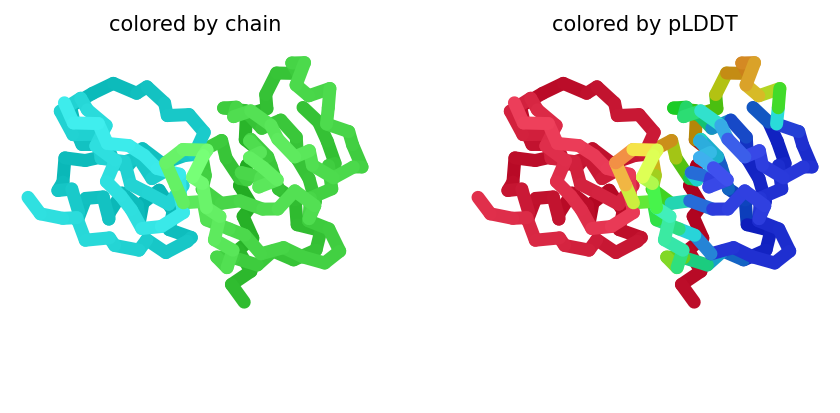

2025-09-08 01:32:33,828 alphafold2_multimer_v3_model_5_seed_003 recycle=0 pLDDT=50.4 pTM=0.507 ipTM=0.136
2025-09-08 01:32:42,533 alphafold2_multimer_v3_model_5_seed_003 recycle=1 pLDDT=51.2 pTM=0.5 ipTM=0.103 tol=2.94
2025-09-08 01:32:51,152 alphafold2_multimer_v3_model_5_seed_003 recycle=2 pLDDT=53.9 pTM=0.52 ipTM=0.131 tol=5.71
2025-09-08 01:32:59,777 alphafold2_multimer_v3_model_5_seed_003 recycle=3 pLDDT=54.9 pTM=0.539 ipTM=0.158 tol=2.77
2025-09-08 01:33:08,416 alphafold2_multimer_v3_model_5_seed_003 recycle=4 pLDDT=55.2 pTM=0.539 ipTM=0.158 tol=2.26
2025-09-08 01:33:17,048 alphafold2_multimer_v3_model_5_seed_003 recycle=5 pLDDT=54.4 pTM=0.535 ipTM=0.155 tol=2.01
2025-09-08 01:33:25,684 alphafold2_multimer_v3_model_5_seed_003 recycle=6 pLDDT=54.8 pTM=0.539 ipTM=0.162 tol=1.63
2025-09-08 01:33:34,327 alphafold2_multimer_v3_model_5_seed_003 recycle=7 pLDDT=54.5 pTM=0.536 ipTM=0.163 tol=0.864
2025-09-08 01:33:43,024 alphafold2_multimer_v3_model_5_seed_003 recycle=8 pLDDT=54.2 pTM=0.

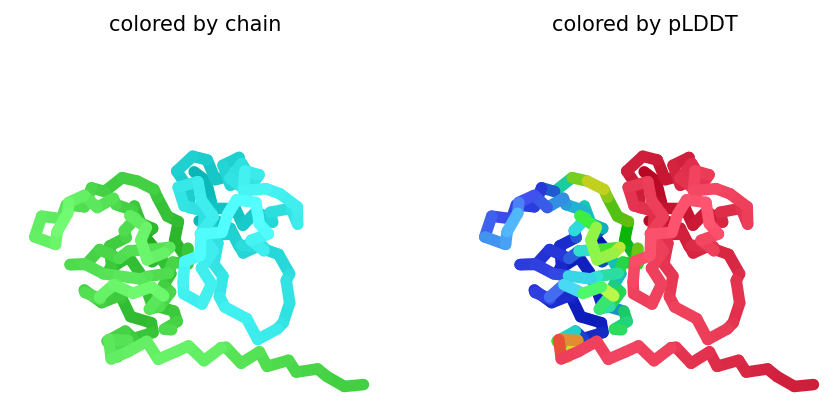

2025-09-08 01:34:26,461 alphafold2_multimer_v3_model_1_seed_004 recycle=0 pLDDT=46 pTM=0.481 ipTM=0.129
2025-09-08 01:34:35,092 alphafold2_multimer_v3_model_1_seed_004 recycle=1 pLDDT=49.8 pTM=0.498 ipTM=0.126 tol=3.56
2025-09-08 01:34:43,784 alphafold2_multimer_v3_model_1_seed_004 recycle=2 pLDDT=50.9 pTM=0.502 ipTM=0.125 tol=6.09
2025-09-08 01:34:52,412 alphafold2_multimer_v3_model_1_seed_004 recycle=3 pLDDT=51.8 pTM=0.506 ipTM=0.135 tol=2.57
2025-09-08 01:35:01,051 alphafold2_multimer_v3_model_1_seed_004 recycle=4 pLDDT=52.5 pTM=0.52 ipTM=0.156 tol=1.73
2025-09-08 01:35:09,692 alphafold2_multimer_v3_model_1_seed_004 recycle=5 pLDDT=52.8 pTM=0.517 ipTM=0.154 tol=1.28
2025-09-08 01:35:18,323 alphafold2_multimer_v3_model_1_seed_004 recycle=6 pLDDT=52.5 pTM=0.516 ipTM=0.146 tol=1.41
2025-09-08 01:35:26,957 alphafold2_multimer_v3_model_1_seed_004 recycle=7 pLDDT=53.5 pTM=0.521 ipTM=0.156 tol=1.33
2025-09-08 01:35:35,596 alphafold2_multimer_v3_model_1_seed_004 recycle=8 pLDDT=53.1 pTM=0.5

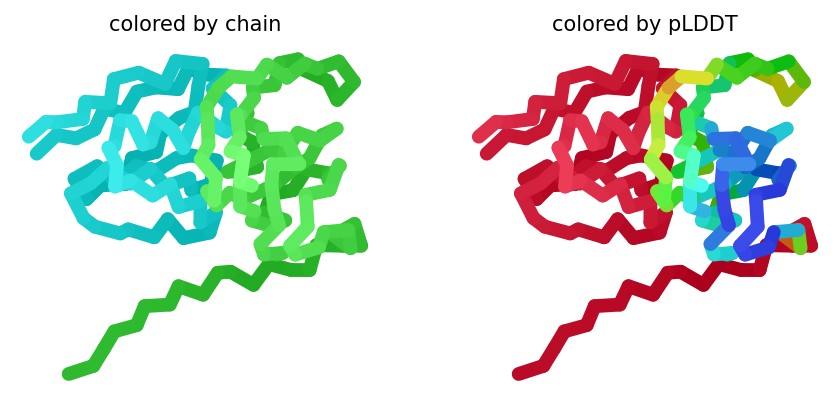

2025-09-08 01:36:19,122 alphafold2_multimer_v3_model_2_seed_004 recycle=0 pLDDT=47.5 pTM=0.468 ipTM=0.113
2025-09-08 01:36:27,767 alphafold2_multimer_v3_model_2_seed_004 recycle=1 pLDDT=51.8 pTM=0.492 ipTM=0.0999 tol=4.48
2025-09-08 01:36:36,395 alphafold2_multimer_v3_model_2_seed_004 recycle=2 pLDDT=50.8 pTM=0.487 ipTM=0.101 tol=3.84
2025-09-08 01:36:45,088 alphafold2_multimer_v3_model_2_seed_004 recycle=3 pLDDT=51.9 pTM=0.49 ipTM=0.109 tol=2.46
2025-09-08 01:36:53,719 alphafold2_multimer_v3_model_2_seed_004 recycle=4 pLDDT=52.4 pTM=0.502 ipTM=0.123 tol=1.47
2025-09-08 01:37:02,363 alphafold2_multimer_v3_model_2_seed_004 recycle=5 pLDDT=54.2 pTM=0.51 ipTM=0.137 tol=2.07
2025-09-08 01:37:11,003 alphafold2_multimer_v3_model_2_seed_004 recycle=6 pLDDT=55.8 pTM=0.525 ipTM=0.144 tol=1.36
2025-09-08 01:37:19,696 alphafold2_multimer_v3_model_2_seed_004 recycle=7 pLDDT=56.6 pTM=0.527 ipTM=0.148 tol=0.834
2025-09-08 01:37:28,331 alphafold2_multimer_v3_model_2_seed_004 recycle=8 pLDDT=56.4 pTM=

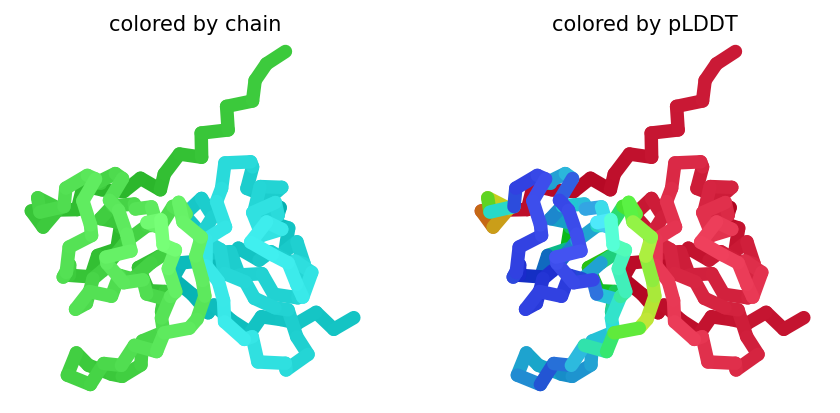

2025-09-08 01:38:11,701 alphafold2_multimer_v3_model_3_seed_004 recycle=0 pLDDT=51.4 pTM=0.498 ipTM=0.167
2025-09-08 01:38:20,381 alphafold2_multimer_v3_model_3_seed_004 recycle=1 pLDDT=53 pTM=0.501 ipTM=0.147 tol=4.55
2025-09-08 01:38:28,988 alphafold2_multimer_v3_model_3_seed_004 recycle=2 pLDDT=54.4 pTM=0.502 ipTM=0.151 tol=3.88
2025-09-08 01:38:37,600 alphafold2_multimer_v3_model_3_seed_004 recycle=3 pLDDT=58.5 pTM=0.518 ipTM=0.167 tol=6.97
2025-09-08 01:38:46,218 alphafold2_multimer_v3_model_3_seed_004 recycle=4 pLDDT=58.4 pTM=0.531 ipTM=0.184 tol=1.91
2025-09-08 01:38:54,836 alphafold2_multimer_v3_model_3_seed_004 recycle=5 pLDDT=61.4 pTM=0.562 ipTM=0.251 tol=1.64
2025-09-08 01:39:03,457 alphafold2_multimer_v3_model_3_seed_004 recycle=6 pLDDT=65.7 pTM=0.625 ipTM=0.389 tol=1
2025-09-08 01:39:12,077 alphafold2_multimer_v3_model_3_seed_004 recycle=7 pLDDT=67.3 pTM=0.638 ipTM=0.425 tol=0.519
2025-09-08 01:39:20,739 alphafold2_multimer_v3_model_3_seed_004 recycle=8 pLDDT=68.5 pTM=0.64

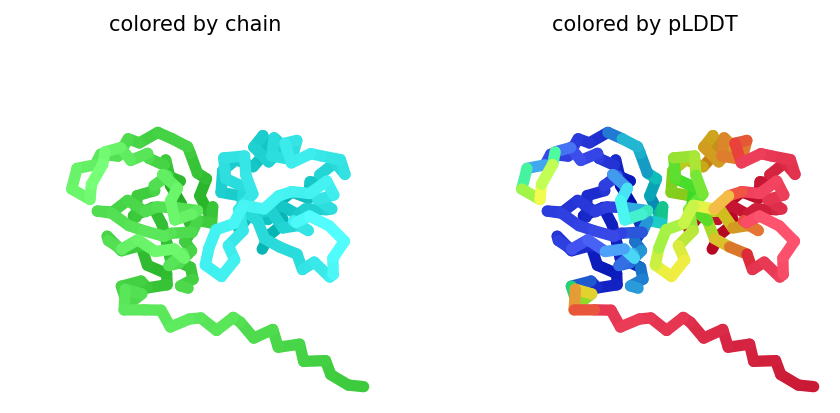

2025-09-08 01:39:46,817 alphafold2_multimer_v3_model_4_seed_004 recycle=0 pLDDT=48.5 pTM=0.501 ipTM=0.158
2025-09-08 01:39:55,445 alphafold2_multimer_v3_model_4_seed_004 recycle=1 pLDDT=52.6 pTM=0.512 ipTM=0.142 tol=3.67
2025-09-08 01:40:04,074 alphafold2_multimer_v3_model_4_seed_004 recycle=2 pLDDT=54.7 pTM=0.521 ipTM=0.157 tol=5.79
2025-09-08 01:40:12,696 alphafold2_multimer_v3_model_4_seed_004 recycle=3 pLDDT=56.1 pTM=0.528 ipTM=0.165 tol=3.39
2025-09-08 01:40:21,381 alphafold2_multimer_v3_model_4_seed_004 recycle=4 pLDDT=55.8 pTM=0.538 ipTM=0.183 tol=1.33
2025-09-08 01:40:30,030 alphafold2_multimer_v3_model_4_seed_004 recycle=5 pLDDT=56 pTM=0.537 ipTM=0.185 tol=1.14
2025-09-08 01:40:38,669 alphafold2_multimer_v3_model_4_seed_004 recycle=6 pLDDT=56.5 pTM=0.544 ipTM=0.188 tol=0.729
2025-09-08 01:40:47,301 alphafold2_multimer_v3_model_4_seed_004 recycle=7 pLDDT=56.8 pTM=0.542 ipTM=0.184 tol=2.09
2025-09-08 01:40:55,947 alphafold2_multimer_v3_model_4_seed_004 recycle=8 pLDDT=57.1 pTM=0

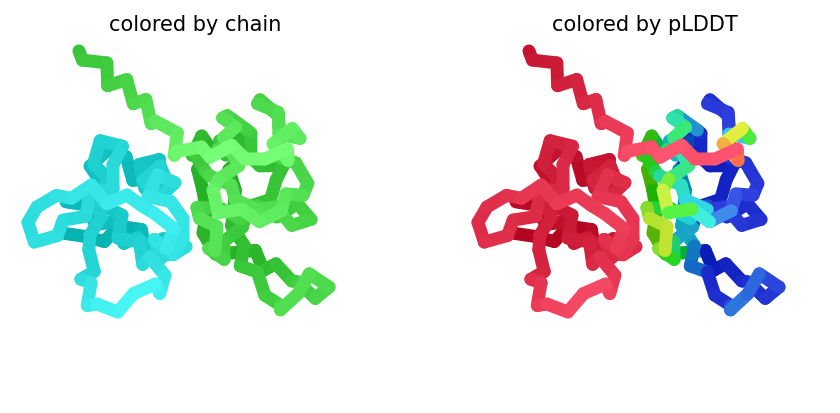

2025-09-08 01:41:39,446 alphafold2_multimer_v3_model_5_seed_004 recycle=0 pLDDT=49.2 pTM=0.499 ipTM=0.171
2025-09-08 01:41:48,090 alphafold2_multimer_v3_model_5_seed_004 recycle=1 pLDDT=50.9 pTM=0.504 ipTM=0.14 tol=4.47
2025-09-08 01:41:56,772 alphafold2_multimer_v3_model_5_seed_004 recycle=2 pLDDT=50.9 pTM=0.506 ipTM=0.133 tol=5.49
2025-09-08 01:42:05,412 alphafold2_multimer_v3_model_5_seed_004 recycle=3 pLDDT=54.5 pTM=0.525 ipTM=0.155 tol=4.59
2025-09-08 01:42:14,050 alphafold2_multimer_v3_model_5_seed_004 recycle=4 pLDDT=55.2 pTM=0.541 ipTM=0.177 tol=2.37
2025-09-08 01:42:22,704 alphafold2_multimer_v3_model_5_seed_004 recycle=5 pLDDT=55.1 pTM=0.539 ipTM=0.176 tol=1.82
2025-09-08 01:42:31,340 alphafold2_multimer_v3_model_5_seed_004 recycle=6 pLDDT=55.1 pTM=0.542 ipTM=0.17 tol=2.92
2025-09-08 01:42:39,980 alphafold2_multimer_v3_model_5_seed_004 recycle=7 pLDDT=55 pTM=0.54 ipTM=0.173 tol=2.4
2025-09-08 01:42:48,619 alphafold2_multimer_v3_model_5_seed_004 recycle=8 pLDDT=56.9 pTM=0.561 

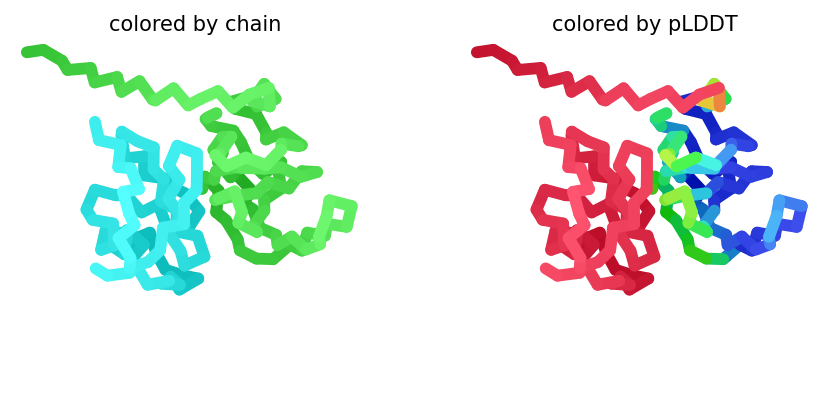

2025-09-08 01:43:32,077 alphafold2_multimer_v3_model_1_seed_005 recycle=0 pLDDT=46.7 pTM=0.483 ipTM=0.127
2025-09-08 01:43:40,707 alphafold2_multimer_v3_model_1_seed_005 recycle=1 pLDDT=50.1 pTM=0.504 ipTM=0.138 tol=6.34
2025-09-08 01:43:49,338 alphafold2_multimer_v3_model_1_seed_005 recycle=2 pLDDT=52.6 pTM=0.522 ipTM=0.16 tol=3.2
2025-09-08 01:43:58,028 alphafold2_multimer_v3_model_1_seed_005 recycle=3 pLDDT=53.8 pTM=0.524 ipTM=0.15 tol=2.28
2025-09-08 01:44:06,652 alphafold2_multimer_v3_model_1_seed_005 recycle=4 pLDDT=53.1 pTM=0.52 ipTM=0.146 tol=1.82
2025-09-08 01:44:15,285 alphafold2_multimer_v3_model_1_seed_005 recycle=5 pLDDT=53.7 pTM=0.529 ipTM=0.165 tol=1.09
2025-09-08 01:44:23,918 alphafold2_multimer_v3_model_1_seed_005 recycle=6 pLDDT=54 pTM=0.533 ipTM=0.174 tol=1.22
2025-09-08 01:44:32,554 alphafold2_multimer_v3_model_1_seed_005 recycle=7 pLDDT=53.9 pTM=0.537 ipTM=0.177 tol=1.52
2025-09-08 01:44:41,190 alphafold2_multimer_v3_model_1_seed_005 recycle=8 pLDDT=54.8 pTM=0.539 

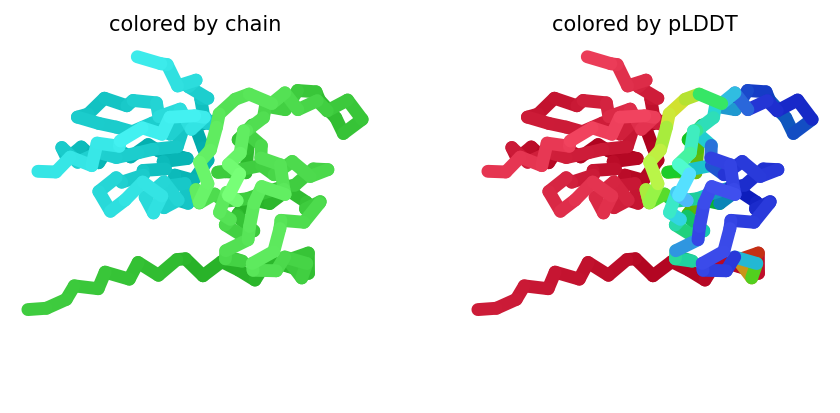

2025-09-08 01:45:24,630 alphafold2_multimer_v3_model_2_seed_005 recycle=0 pLDDT=47.1 pTM=0.476 ipTM=0.111
2025-09-08 01:45:33,322 alphafold2_multimer_v3_model_2_seed_005 recycle=1 pLDDT=51.2 pTM=0.499 ipTM=0.122 tol=5.25
2025-09-08 01:45:41,949 alphafold2_multimer_v3_model_2_seed_005 recycle=2 pLDDT=51.4 pTM=0.495 ipTM=0.116 tol=3.6
2025-09-08 01:45:50,566 alphafold2_multimer_v3_model_2_seed_005 recycle=3 pLDDT=54.7 pTM=0.514 ipTM=0.129 tol=1.75
2025-09-08 01:45:59,241 alphafold2_multimer_v3_model_2_seed_005 recycle=4 pLDDT=54.8 pTM=0.518 ipTM=0.133 tol=0.733
2025-09-08 01:46:07,892 alphafold2_multimer_v3_model_2_seed_005 recycle=5 pLDDT=55 pTM=0.517 ipTM=0.131 tol=0.896
2025-09-08 01:46:16,519 alphafold2_multimer_v3_model_2_seed_005 recycle=6 pLDDT=55 pTM=0.52 ipTM=0.131 tol=0.7
2025-09-08 01:46:25,145 alphafold2_multimer_v3_model_2_seed_005 recycle=7 pLDDT=55.5 pTM=0.531 ipTM=0.135 tol=0.649
2025-09-08 01:46:33,836 alphafold2_multimer_v3_model_2_seed_005 recycle=8 pLDDT=55.7 pTM=0.52

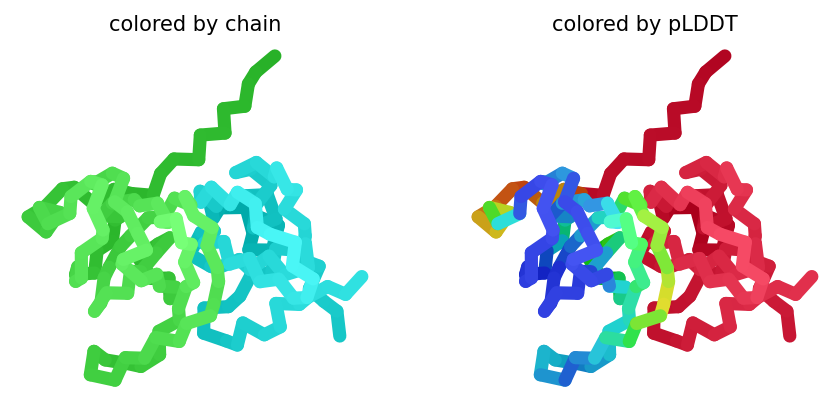

2025-09-08 01:47:17,234 alphafold2_multimer_v3_model_3_seed_005 recycle=0 pLDDT=51.3 pTM=0.484 ipTM=0.124
2025-09-08 01:47:25,858 alphafold2_multimer_v3_model_3_seed_005 recycle=1 pLDDT=51.5 pTM=0.486 ipTM=0.132 tol=3.23
2025-09-08 01:47:34,554 alphafold2_multimer_v3_model_3_seed_005 recycle=2 pLDDT=51.6 pTM=0.48 ipTM=0.119 tol=1.77
2025-09-08 01:47:43,183 alphafold2_multimer_v3_model_3_seed_005 recycle=3 pLDDT=51.9 pTM=0.489 ipTM=0.137 tol=1.83
2025-09-08 01:47:51,805 alphafold2_multimer_v3_model_3_seed_005 recycle=4 pLDDT=51.4 pTM=0.485 ipTM=0.125 tol=2.27
2025-09-08 01:48:00,447 alphafold2_multimer_v3_model_3_seed_005 recycle=5 pLDDT=52.4 pTM=0.496 ipTM=0.139 tol=1.78
2025-09-08 01:48:09,086 alphafold2_multimer_v3_model_3_seed_005 recycle=6 pLDDT=53.4 pTM=0.503 ipTM=0.132 tol=4.37
2025-09-08 01:48:17,711 alphafold2_multimer_v3_model_3_seed_005 recycle=7 pLDDT=53.8 pTM=0.508 ipTM=0.146 tol=2.6
2025-09-08 01:48:26,353 alphafold2_multimer_v3_model_3_seed_005 recycle=8 pLDDT=55.5 pTM=0.

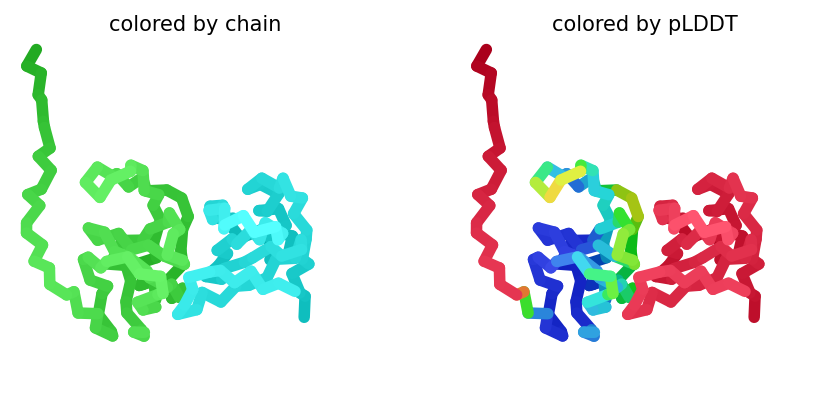

2025-09-08 01:49:09,815 alphafold2_multimer_v3_model_4_seed_005 recycle=0 pLDDT=49.5 pTM=0.494 ipTM=0.156
2025-09-08 01:49:18,436 alphafold2_multimer_v3_model_4_seed_005 recycle=1 pLDDT=51.2 pTM=0.505 ipTM=0.145 tol=4.02
2025-09-08 01:49:27,057 alphafold2_multimer_v3_model_4_seed_005 recycle=2 pLDDT=54.4 pTM=0.515 ipTM=0.137 tol=5.21
2025-09-08 01:49:35,770 alphafold2_multimer_v3_model_4_seed_005 recycle=3 pLDDT=56.5 pTM=0.523 ipTM=0.139 tol=1.5
2025-09-08 01:49:44,403 alphafold2_multimer_v3_model_4_seed_005 recycle=4 pLDDT=55.8 pTM=0.528 ipTM=0.14 tol=1.33
2025-09-08 01:49:53,042 alphafold2_multimer_v3_model_4_seed_005 recycle=5 pLDDT=56.3 pTM=0.533 ipTM=0.157 tol=1.07
2025-09-08 01:50:01,686 alphafold2_multimer_v3_model_4_seed_005 recycle=6 pLDDT=56.2 pTM=0.533 ipTM=0.157 tol=2
2025-09-08 01:50:10,320 alphafold2_multimer_v3_model_4_seed_005 recycle=7 pLDDT=56.5 pTM=0.538 ipTM=0.173 tol=1.75
2025-09-08 01:50:18,954 alphafold2_multimer_v3_model_4_seed_005 recycle=8 pLDDT=56.8 pTM=0.539

In [ ]:
#@title Run Prediction
display_images = True #@param {type:"boolean"}

import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
from pathlib import Path
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2

import os
import numpy as np
try:
  K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
except:
  K80_chk = "0"
  pass
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt

# For some reason we need that to get pdbfixer to import
if use_amber and f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
    sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")

def input_features_callback(input_features):
  if display_images:
    plot_msa_v2(input_features)
    plt.show()
    plt.close()

def prediction_callback(protein_obj, length,
                        prediction_result, input_features, mode):
  model_name, relaxed = mode
  if not relaxed:
    if display_images:
      fig = plot_protein(protein_obj, Ls=length, dpi=150)
      plt.show()
      plt.close()

result_dir = jobname
log_filename = os.path.join(jobname,"log.txt")
setup_logging(Path(log_filename))

queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)

if "multimer" in model_type and max_msa is not None:
  use_cluster_profile = False
else:
  use_cluster_profile = True

download_alphafold_params(model_type, Path("."))
results = run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    num_relax=num_relax,
    msa_mode=msa_mode,
    model_type=model_type,
    num_models=5,
    num_recycles=num_recycles,
    relax_max_iterations=relax_max_iterations,
    recycle_early_stop_tolerance=recycle_early_stop_tolerance,
    num_seeds=num_seeds,
    use_dropout=use_dropout,
    model_order=[1,2,3,4,5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode=pair_mode,
    pairing_strategy=pairing_strategy,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=dpi,
    zip_results=False,
    save_all=save_all,
    max_msa=max_msa,
    use_cluster_profile=use_cluster_profile,
    input_features_callback=input_features_callback,
    save_recycles=save_recycles,
    user_agent="colabfold/google-colab-main",
    calc_extra_ptm=calc_extra_ptm,
)
results_zip = f"{jobname}.result.zip"
os.system(f"zip -r {results_zip} {jobname}")

In [ ]:
#@title Display 3D structure {run: "auto"}
import py3Dmol
import glob
import matplotlib.pyplot as plt
from colabfold.colabfold import plot_plddt_legend
from colabfold.colabfold import pymol_color_list, alphabet_list
rank_num = 1 #@param ["1", "2", "3", "4", "5"] {type:"raw"}
color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

tag = results["rank"][0][rank_num - 1]
jobname_prefix = ".custom" if msa_mode == "custom" else ""
pdb_filename = f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_{tag}.pdb"
pdb_file = glob.glob(pdb_filename)

def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"rank_{rank_num}"
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_file[0],'r').read(),'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})

  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view

show_pdb(rank_num, show_sidechains, show_mainchains, color).show()
if color == "lDDT":
  plot_plddt_legend().show()

In [ ]:
#@title Plots {run: "auto"}
from IPython.display import display, HTML
import base64
from html import escape

# see: https://stackoverflow.com/a/53688522
def image_to_data_url(filename):
  ext = filename.split('.')[-1]
  prefix = f'data:image/{ext};base64,'
  with open(filename, 'rb') as f:
    img = f.read()
  return prefix + base64.b64encode(img).decode('utf-8')

pae = ""
pae_file = os.path.join(jobname,f"{jobname}{jobname_prefix}_pae.png")
if os.path.isfile(pae_file):
    pae = image_to_data_url(pae_file)
cov = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_coverage.png"))
plddt = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_plddt.png"))
display(HTML(f"""
<style>
  img {{
    float:left;
  }}
  .full {{
    max-width:100%;
  }}
  .half {{
    max-width:50%;
  }}
  @media (max-width:640px) {{
    .half {{
      max-width:100%;
    }}
  }}
</style>
<div style="max-width:90%; padding:2em;">
  <h1>Plots for {escape(jobname)}</h1>
  { '<!--' if pae == '' else '' }<img src="{pae}" class="full" />{ '-->' if pae == '' else '' }
  <img src="{cov}" class="half" />
  <img src="{plddt}" class="half" />
</div>
"""))

In [ ]:
#@title Package and download results
#@markdown If you are having issues downloading the result archive, try disabling your adblocker and run this cell again. If that fails click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).

if msa_mode == "custom":
  print("Don't forget to cite your custom MSA generation method.")

files.download(f"{jobname}.result.zip")

if save_to_google_drive == True and drive:
  uploaded = drive.CreateFile({'title': f"{jobname}.result.zip"})
  uploaded.SetContentFile(f"{jobname}.result.zip")
  uploaded.Upload()
  print(f"Uploaded {jobname}.result.zip to Google Drive with ID {uploaded.get('id')}")

# Instructions <a name="Instructions"></a>
For detailed instructions, tips and tricks, see recently published paper at [Nature Protocols](https://www.nature.com/articles/s41596-024-01060-5)

**Quick start**
1. Paste your protein sequence(s) in the input field.
2. Press "Runtime" -> "Run all".
3. The pipeline consists of 5 steps. The currently running step is indicated by a circle with a stop sign next to it.

**Result zip file contents**

1. PDB formatted structures sorted by avg. pLDDT and complexes are sorted by pTMscore. (unrelaxed and relaxed if `use_amber` is enabled).
2. Plots of the model quality.
3. Plots of the MSA coverage.
4. Parameter log file.
5. A3M formatted input MSA.
6. A `predicted_aligned_error_v1.json` using [AlphaFold-DB's format](https://alphafold.ebi.ac.uk/faq#faq-7) and a `scores.json` for each model which contains an array (list of lists) for PAE, a list with the average pLDDT and the pTMscore.
7. BibTeX file with citations for all used tools and databases.

At the end of the job a download modal box will pop up with a `jobname.result.zip` file. Additionally, if the `save_to_google_drive` option was selected, the `jobname.result.zip` will be uploaded to your Google Drive.

**MSA generation for complexes**

For the complex prediction we use unpaired and paired MSAs. Unpaired MSA is generated the same way as for the protein structures prediction by searching the UniRef100 and environmental sequences three iterations each.

The paired MSA is generated by searching the UniRef100 database and pairing the best hits sharing the same NCBI taxonomic identifier (=species or sub-species). We only pair sequences if all of the query sequences are present for the respective taxonomic identifier.

**Using a custom MSA as input**

To predict the structure with a custom MSA (A3M formatted): (1) Change the `msa_mode`: to "custom", (2) Wait for an upload box to appear at the end of the "MSA options ..." box. Upload your A3M. The first fasta entry of the A3M must be the query sequence without gaps.

It is also possilbe to provide custom MSAs for complex predictions. Read more about the format [here](https://github.com/sokrypton/ColabFold/issues/76).

As an alternative for MSA generation the [HHblits Toolkit server](https://toolkit.tuebingen.mpg.de/tools/hhblits) can be used. After submitting your query, click "Query Template MSA" -> "Download Full A3M". Download the A3M file and upload it in this notebook.

**PDB100** <a name="pdb100"></a>

As of 23/06/08, we have transitioned from using the PDB70 to a 100% clustered PDB, the PDB100. The construction methodology of PDB100 differs from that of PDB70.

The PDB70 was constructed by running each PDB70 representative sequence through [HHblits](https://github.com/soedinglab/hh-suite) against the [Uniclust30](https://uniclust.mmseqs.com/). On the other hand, the PDB100 is built by searching each PDB100 representative structure with [Foldseek](https://github.com/steineggerlab/foldseek) against the [AlphaFold Database](https://alphafold.ebi.ac.uk).

To maintain compatibility with older Notebook versions and local installations, the generated files and API responses will continue to be named "PDB70", even though we're now using the PDB100.

**Using custom templates** <a name="custom_templates"></a>

To predict the structure with a custom template (PDB or mmCIF formatted): (1) change the `template_mode` to "custom" in the execute cell and (2) wait for an upload box to appear at the end of the "Input Protein" box. Select and upload your templates (multiple choices are possible).

* Templates must follow the four letter PDB naming with lower case letters.

* Templates in mmCIF format must contain `_entity_poly_seq`. An error is thrown if this field is not present. The field `_pdbx_audit_revision_history.revision_date` is automatically generated if it is not present.

* Templates in PDB format are automatically converted to the mmCIF format. `_entity_poly_seq` and `_pdbx_audit_revision_history.revision_date` are automatically generated.

If you encounter problems, please report them to this [issue](https://github.com/sokrypton/ColabFold/issues/177).

**Comparison to the full AlphaFold2 and AlphaFold2 Colab**

This notebook replaces the homology detection and MSA pairing of AlphaFold2 with MMseqs2. For a comparison against the [AlphaFold2 Colab](https://colab.research.google.com/github/deepmind/alphafold/blob/main/notebooks/AlphaFold.ipynb) and the full [AlphaFold2](https://github.com/deepmind/alphafold) system read our [paper](https://www.nature.com/articles/s41592-022-01488-1).

**Troubleshooting**
* Check that the runtime type is set to GPU at "Runtime" -> "Change runtime type".
* Try to restart the session "Runtime" -> "Factory reset runtime".
* Check your input sequence.

**Known issues**
* Google Colab assigns different types of GPUs with varying amount of memory. Some might not have enough memory to predict the structure for a long sequence.
* Your browser can block the pop-up for downloading the result file. You can choose the `save_to_google_drive` option to upload to Google Drive instead or manually download the result file: Click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).

**Limitations**
* Computing resources: Our MMseqs2 API can handle ~20-50k requests per day.
* MSAs: MMseqs2 is very precise and sensitive but might find less hits compared to HHblits/HMMer searched against BFD or MGnify.
* We recommend to additionally use the full [AlphaFold2 pipeline](https://github.com/deepmind/alphafold).

**Description of the plots**
*   **Number of sequences per position** - We want to see at least 30 sequences per position, for best performance, ideally 100 sequences.
*   **Predicted lDDT per position** - model confidence (out of 100) at each position. The higher the better.
*   **Predicted Alignment Error** - For homooligomers, this could be a useful metric to assess how confident the model is about the interface. The lower the better.

**Bugs**
- If you encounter any bugs, please report the issue to https://github.com/sokrypton/ColabFold/issues

**License**

The source code of ColabFold is licensed under [MIT](https://raw.githubusercontent.com/sokrypton/ColabFold/main/LICENSE). Additionally, this notebook uses the AlphaFold2 source code and its parameters licensed under [Apache 2.0](https://raw.githubusercontent.com/deepmind/alphafold/main/LICENSE) and [CC BY 4.0](https://creativecommons.org/licenses/by-sa/4.0/) respectively. Read more about the AlphaFold license [here](https://github.com/deepmind/alphafold).

**Acknowledgments**
- We thank the AlphaFold team for developing an excellent model and open sourcing the software.

- [KOBIC](https://kobic.re.kr) and [Söding Lab](https://www.mpinat.mpg.de/soeding) for providing the computational resources for the MMseqs2 MSA server.

- Richard Evans for helping to benchmark the ColabFold's Alphafold-multimer support.

- [David Koes](https://github.com/dkoes) for his awesome [py3Dmol](https://3dmol.csb.pitt.edu/) plugin, without whom these notebooks would be quite boring!

- Do-Yoon Kim for creating the ColabFold logo.

- A colab by Sergey Ovchinnikov ([@sokrypton](https://twitter.com/sokrypton)), Milot Mirdita ([@milot_mirdita](https://twitter.com/milot_mirdita)) and Martin Steinegger ([@thesteinegger](https://twitter.com/thesteinegger)).
